## Data Loader

In [1]:
"""
modified from https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/datasets.py
"""
from pathlib import Path
from tqdm import tqdm

# from toolz import *
# from toolz.curried import *
# from toolz.curried.operator import *

import pandas as pd

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class EmoryDataset(Dataset):

    split_ratio = [0.6, 0.2, 0.2]

    embed_prefix = "embds"

    pathologies = ["Enlarged Cardiomediastinum",
                   "Cardiomegaly",
                   "Lung Opacity",
                   "Lung Lesion",
                   "Edema",
                   "Consolidation",
                   "Pneumonia",
                   "Atelectasis",
                   "Pneumothorax",
                   "Pleural Effusion",
                   "Pleural Other",
                   "Fracture",
                   "Support Devices"]


    embedding_d = {
        "BiomedCLIP": Path("~/fsx/embeddings/EmoryCXR/embds_BiomedCLIP"), 
        "CheXagent": Path("~/fsx/embeddings/EmoryCXR/embds_CheXagent"), 
        "MedGemma": Path("~/fsx/embeddings/EmoryCXR/embds_MedGemma"),
        "RAD-DINO": Path("~/fsx/embeddings/EmoryCXR/embds_RAD-DINO"),
    }

    csvpath = Path("~/fsx/embeddings/EmoryCXR/Tables/EmoryCXR_v2_FindingLabel_10162024.csv")
    metacsvpath = Path("~/fsx/embeddings/EmoryCXR/Tables/EmoryCXR_v2_metadata_08152025.csv")
    base_dicom_path = Path("/home/jupyter-oluwatunmise/fsx/embeddings/EmoryCXR/")

    def __init__(
        self,
        views: str = ["PA", "AP"][0],
        mode: str = ["train", "validate", "test"][0],
        embedding_type: str = ["BiomedCLIP", "CheXagent", "MedGemma", "RAD-DINO", "All"][0],       
        unique_patients=True,
        seed : int = 0):
        
        np.random.seed(seed)  # Reset the seed so all runs are the same.        
        self.views = views
        self.mode = mode
        self.embedding_type = embedding_type
        self.unique_patients = unique_patients        
        self.seed = seed
        
        self.embpath: str | list[str] = self.load_emb_path(embedding_type)
            
        self.csv = pd.read_csv(self.csvpath)
        self.metacsv = pd.read_csv(self.metacsvpath)
        self.csv = self.csv.set_index(["AccessionNumber_anon"])
        self.metacsv = self.metacsv.set_index(["AccessionNumber_anon"])
        self.csv = self.csv.join(self.metacsv).reset_index()   

        # Keep only the desired view
        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)
    
        if unique_patients:
            self.csv = self.csv.groupby("empi_anon").first().reset_index()
            
        self.csv = self.csv.sample(frac=1, random_state=self.seed).reset_index(drop=True)
        self.csv = self.csv.fillna(0)
        self.csv = self.csv[:10000]
        
        n_row = self.csv.shape[0]
        
        # spit data to one of train valid test
        if self.mode == "train":
            self.csv = self.csv[: int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[
                int(n_row * self.split_ratio[0]) : int(
                    n_row * (self.split_ratio[0] + self.split_ratio[1])
                )
            ]            
        elif self.mode == "test":
            self.csv = self.csv[-int(n_row * self.split_ratio[-1]) :]
        else:
            raise ValueError(
                f"attr:mode has to be one of [train, valid, test] but your input is {self.mode}"
            )

        # Get our classes.
        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]

            labels.append(mask.values)
        self.labels = np.asarray(labels).T
        self.labels = self.labels.astype(np.float32)

        # Make all the -1 values into nans to keep things simple
        self.labels[self.labels == -1] = 0

        # Rename pathologies
        #self.pathologies = list(np.char.replace(self.pathologies, "Pleural Effusion", "Effusion"))
        # add consistent csv values

        # patientid
        self.csv["empi_anon"] = self.csv["empi_anon"].astype(str)

    def __getitem__(self, i):        
        sample = {}
        sample["patient_id"] = int(float(self.csv.iloc[i]["empi_anon"]))
        sample["study_id"] = int(float(self.csv.iloc[i]["AccessionNumber_anon"]))
        sample["lab"] = self.labels[i]
        sample["emb"] = self.load_embedding(self.csv.iloc[i]["SOP"])

        return sample

    def __len__(self):
        return len(self.labels)        
        

    def load_emb_path(self, embedding_type):
        if self.embedding_type != "All":
            return self.embedding_d[embedding_type]
        else:            
            return list(self.embedding_d.values())

    def limit_to_selected_views(self, views):
        """This function is called by subclasses to filter the
        images by view based on the values in .csv['view']
        """
        if type(views) is not list:
            views = [views]
        if '*' in views:
            # if you have the wildcard, the rest are irrelevant
            views = ["*"]
        self.views = views

        # missing data is unknown
        self.csv = self.csv.copy()
        self.csv["view"] = self.csv["view"].fillna("UNKNOWN")

        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]  # Select the view
    
    def load_embedding(self, embedding_id):
        if self.embedding_type == "All":
            merged_emb = []
            for embedding_type in list(self.embedding_d.keys()):
                emb = np.load(f"{self.base_dicom_path/('embds_'+ embedding_type)/embedding_id}.npy")
                merged_emb.append(emb)
            return np.concat(merged_emb)                
        else:
            return np.load(f"{self.base_dicom_path/('embds_'+ self.embedding_type)/embedding_id}.npy")

    def load_all(self):
        print(f"loading all {self.mode} data")
        samples = []
        for i in tqdm(range(self.__len__())):
            sample = self.__getitem__(i)
            samples.append(sample)
        return samples


class Dataloader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=8,
        collate_fn=None,
        pin_memory=True,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
        multiprocessing_context=None,
        generator=None,
        prefetch_factor=None,
        persistent_workers=False,
        **kwargs
    ):

        # Initialize the parent class with all arguments
        super().__init__(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=collate_fn,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            multiprocessing_context=multiprocessing_context,
            generator=generator,
            prefetch_factor=prefetch_factor,
            persistent_workers=persistent_workers,
            **kwargs
        )

## Retrieving FMs into Dictionary

In [3]:
import numpy as np, pandas as pd, random, matplotlib.pyplot as plt, seaborn as sns
from typing import List, Dict, Tuple

# --- If you ALREADY built lists like biomedclip_train_dataset, we’ll use them.
# Otherwise we’ll construct them from MimicDataset on the fly.
FMS = ["BiomedCLIP", "CheXagent", "MedGemma", "RAD-DINO"]

def build_split(views, mode, embedding_type, unique_patients=True, seed=0):
    return EmoryDataset(
        views=views, mode=mode, embedding_type=embedding_type,
        unique_patients=unique_patients, seed=seed
    ).load_all()

def get_or_build_split(name: str, fm: str):
    # name ∈ {"train","valid","test"}; pick from existing variables if present
    # Your variables were lowercase: biomedclip_train_dataset, etc.
    var_map = {
        ("BiomedCLIP","train"): "biomedclip_train_dataset",
        ("BiomedCLIP","valid"): "biomedclip_valid_dataset",
        ("BiomedCLIP","test"):  "biomedclip_test_dataset",
        ("CheXagent","train"):  "chexagent_train_dataset",
        ("CheXagent","valid"):  "chexagent_valid_dataset",
        ("CheXagent","test"):   "chexagent_test_dataset",
        ("MedGemma","train"):   "medgemma_train_dataset",
        ("MedGemma","valid"):   "medgemma_valid_dataset",
        ("MedGemma","test"):    "medgemma_test_dataset",
        ("RAD-DINO","train"):   "raddino_train_dataset",
        ("RAD-DINO","valid"):   "raddino_valid_dataset",
        ("RAD-DINO","test"):    "raddino_test_dataset",
    }
    varname = var_map.get((fm, name))
    g = globals()
    if varname in g:
        return g[varname]
    # else build
    return build_split("PA", name if name != "valid" else "valid", fm, True, 0)

splits = {"train": {}, "valid": {}, "test": {}}
for fm in FMS:
    splits["train"][fm] = get_or_build_split("train", fm)
    splits["valid"][fm] = get_or_build_split("valid", fm)
    splits["test"][fm]  = get_or_build_split("test", fm)


loading all train data


100%|██████████| 6000/6000 [00:10<00:00, 567.84it/s]


loading all valid data


100%|██████████| 2000/2000 [00:03<00:00, 567.05it/s]


loading all test data


100%|██████████| 2000/2000 [00:03<00:00, 568.54it/s]


loading all train data


100%|██████████| 6000/6000 [00:10<00:00, 562.26it/s]


loading all valid data


100%|██████████| 2000/2000 [00:03<00:00, 562.41it/s]


loading all test data


100%|██████████| 2000/2000 [00:03<00:00, 593.71it/s]


loading all train data


100%|██████████| 6000/6000 [00:13<00:00, 438.80it/s]


loading all valid data


100%|██████████| 2000/2000 [00:03<00:00, 569.04it/s]


loading all test data


100%|██████████| 2000/2000 [00:03<00:00, 575.88it/s]


loading all train data


100%|██████████| 6000/6000 [00:13<00:00, 431.80it/s]


loading all valid data


100%|██████████| 2000/2000 [00:03<00:00, 582.97it/s]


loading all test data


100%|██████████| 2000/2000 [00:03<00:00, 581.84it/s]


## Classification Pipeline

In [4]:
# ===== 1) Helper utilities =====
def subset_samples(samples: List[Dict], n: int = None, seed: int = 0) -> List[Dict]:
    if n is None or n >= len(samples): return samples
    rng = random.Random(seed)
    samples = samples.copy()
    rng.shuffle(samples)
    return samples[:n]

def index_by_key(samples: List[Dict], key="patient_id") -> Dict[int, Dict]:
    d = {}
    for s in samples:
        d[int(s[key])] = s
    return d

def intersect_ids(dicts: List[Dict[int, Dict]]) -> List[int]:
    common = None
    for d in dicts:
        ids = set(d.keys())
        common = ids if common is None else (common & ids)
        if not common: break
    return sorted(list(common)) if common else []

def concat_features_across_fms(fm_to_samples: Dict[str, List[Dict]],
                               id_key="patient_id") -> List[Dict]:
    """
    Align by id_key across FMs; concatenate 'emb'; take 'lab' from first FM.
    """
    fm_dicts = {fm: index_by_key(samps, id_key) for fm, samps in fm_to_samples.items()}
    common = intersect_ids(list(fm_dicts.values()))
    out = []
    if not common:
        return out
    for pid in common:
        embs, lab = [], None
        for fm in fm_dicts:
            s = fm_dicts[fm][pid]
            e = np.asarray(s["emb"])
            if e.ndim > 1: e = e.reshape(-1)
            embs.append(e.astype(np.float32))
            if lab is None:
                lab = np.asarray(s["lab"], dtype=np.float32)
        out.append({
            "patient_id": int(pid),
            "case_id": int(pid),
            "lab": (lab > 0.5).astype(np.int32),
            "emb": np.concatenate(embs, axis=0)
        })
    return out

# ===== 2) Use full data per FM per split (no cap) =====
splits_sampled = {"train": {}, "valid": {}, "test": {}}
for split in ["train", "valid", "test"]:
    for fm in FMS:
        splits_sampled[split][fm] = splits[split][fm]  # keep all samples

# ===== 3) Build concatenated splits =====
concat_splits = {}
for split in ["train","valid","test"]:
    concat_splits[split] = concat_features_across_fms(splits_sampled[split])

# ===== 4) Your MLP pipeline =====
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, average_precision_score

def stack_from_samples(samples: List[Dict]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(samples) == 0: raise ValueError("Empty sample list.")
    X_list, Y_list, ids = [], [], []
    for s in samples:
        emb = np.asarray(s["emb"])
        if emb.ndim > 1: emb = emb.reshape(-1)
        X_list.append(emb.astype(np.float32))
        Y_list.append(np.asarray(s["lab"], dtype=np.float32))
        ids.append(int(s["patient_id"]))
    X = np.vstack(X_list)
    Y = np.vstack(Y_list)
    ids = np.asarray(ids)
    X = np.nan_to_num(X, posinf=0.0, neginf=0.0)
    Y = np.nan_to_num(Y, posinf=0.0, neginf=0.0)
    Y = (Y > 0.5).astype(int)
    return X, Y, ids

def fit_eval_mlp_on_splits(
    train_samples: List[Dict],
    valid_samples: List[Dict],
    test_samples:  List[Dict],
    label_names: List[str],
    seed: int = 0,
    hidden=(512, 256),
    max_iter=20,
) -> Dict[str, Dict[str, float]]:
    X_tr, Y_tr, _ = stack_from_samples(train_samples)
    X_va, Y_va, _ = stack_from_samples(valid_samples)
    X_te, Y_te, _ = stack_from_samples(test_samples)

    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_va_s = scaler.transform(X_va)
    X_te_s = scaler.transform(X_te)

    L = Y_tr.shape[1]
    P_va = np.zeros((X_va_s.shape[0], L), dtype=float)
    P_te = np.zeros((X_te_s.shape[0], L), dtype=float)

    for j in range(L):
        y_tr = Y_tr[:, j]
        if len(np.unique(y_tr)) < 2:
            const_p = float(y_tr.mean())
            P_va[:, j] = const_p
            P_te[:, j] = const_p
            continue

        sw = compute_sample_weight("balanced", y_tr)
        sw
        clf = MLPClassifier(
            hidden_layer_sizes=hidden,
            activation="relu",
            solver="adam",
            alpha=1e-4,
            learning_rate_init=1e-5,
            batch_size=32,
            max_iter=max_iter,
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.15,
            shuffle=True,
            random_state=seed,
        )
        clf.fit(X_tr_s, y_tr, sample_weight=sw)
        P_va[:, j] = clf.predict_proba(X_va_s)[:, 1]
        P_te[:, j] = clf.predict_proba(X_te_s)[:, 1]

    def split_metrics(Y_true: np.ndarray, P: np.ndarray) -> Dict[str, float]:
        per_auc, per_ap, valid_cols = {}, {}, []
        for j, lab in enumerate(label_names):
            yt = Y_true[:, j]
            if len(np.unique(yt)) < 2:
                per_auc[lab] = np.nan
                per_ap[lab]  = np.nan
            else:
                per_auc[lab] = roc_auc_score(yt, P[:, j])
                per_ap[lab]  = average_precision_score(yt, P[:, j])
                valid_cols.append(j)
        auroc_macro = float(np.nanmean(list(per_auc.values()))) if per_auc else np.nan
        ap_macro    = float(np.nanmean(list(per_ap.values())))  if per_ap else np.nan
        if valid_cols:
            auroc_micro = roc_auc_score(Y_true[:, valid_cols], P[:, valid_cols], average="micro")
            ap_micro    = average_precision_score(Y_true[:, valid_cols], P[:, valid_cols], average="micro")
        else:
            auroc_micro = np.nan; ap_micro = np.nan
        return dict(
            AUROC_macro=auroc_macro,
            AP_macro=ap_macro,
            AUROC_micro=auroc_micro,
            AP_micro=ap_micro,
            per_label_AUROC=per_auc,
            per_label_AP=per_ap,
        )

    return {"valid": split_metrics(Y_va, P_va), "test": split_metrics(Y_te, P_te)}

# ===== 5) Labels (Effusion rename) =====
label_cols = [
    "Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
    "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion",
    "Pleural Other","Fracture","Support Devices"
]

## Evaluating Model performance

In [ ]:
# ===== 6) Evaluate: each FM + Concat =====
def eval_all_individual_and_concat(splits_sampled, concat_splits, label_cols,
                                   seed=0, hidden=(512,256), max_iter=120):
    fm_results, fm_perlabel = {}, {}

    for fm in FMS:
        res = fit_eval_mlp_on_splits(
            train_samples=splits_sampled["train"][fm],
            valid_samples=splits_sampled["valid"][fm],
            test_samples=splits_sampled["test"][fm],
            label_names=label_cols,
            seed=seed, hidden=hidden, max_iter=max_iter
        )
        fm_results[fm] = {
            "valid": {k:v for k,v in res["valid"].items() if not isinstance(v, dict)},
            "test":  {k:v for k,v in res["test"].items()  if not isinstance(v, dict)},
        }
        fm_perlabel[fm] = res["test"]["per_label_AUROC"]
        print(f"[{fm}] VALID AUROC_macro={fm_results[fm]['valid']['AUROC_macro']:.4f} "
              f"| AP_macro={fm_results[fm]['valid']['AP_macro']:.4f} "
              f"| AUROC_micro={fm_results[fm]['valid']['AUROC_micro']:.4f} "
              f"| AP_micro={fm_results[fm]['valid']['AP_micro']:.4f}")
        print(f"[{fm}] TEST  AUROC_macro={fm_results[fm]['test']['AUROC_macro']:.4f} "
              f"| AP_macro={fm_results[fm]['test']['AP_macro']:.4f} "
              f"| AUROC_micro={fm_results[fm]['test']['AUROC_micro']:.4f} "
              f"| AP_micro={fm_results[fm]['test']['AP_micro']:.4f}")

    concat_res = fit_eval_mlp_on_splits(
        train_samples=concat_splits["train"],
        valid_samples=concat_splits["valid"],
        test_samples=concat_splits["test"],
        label_names=label_cols,
        seed=seed, hidden=hidden, max_iter=max_iter
    )
    fm_results["Concat"] = {
        "valid": {k:v for k,v in concat_res["valid"].items() if not isinstance(v, dict)},
        "test":  {k:v for k,v in concat_res["test"].items()  if not isinstance(v, dict)},
    }
    fm_perlabel["Concat"] = concat_res["test"]["per_label_AUROC"]
    print(f"[Concat] VALID AUROC_macro={fm_results['Concat']['valid']['AUROC_macro']:.4f} "
          f"| AP_macro={fm_results['Concat']['valid']['AP_macro']:.4f} "
          f"| AUROC_micro={fm_results['Concat']['valid']['AUROC_micro']:.4f} "
          f"| AP_micro={fm_results['Concat']['valid']['AP_micro']:.4f}")
    print(f"[Concat] TEST  AUROC_macro={fm_results['Concat']['test']['AUROC_macro']:.4f} "
          f"| AP_macro={fm_results['Concat']['test']['AP_macro']:.4f} "
          f"| AUROC_micro={fm_results['Concat']['test']['AUROC_micro']:.4f} "
          f"| AP_micro={fm_results['Concat']['test']['AP_micro']:.4f}")

    return fm_results, fm_perlabel

fm_results, fm_perlabel = eval_all_individual_and_concat(
    splits_sampled, concat_splits, label_cols, seed=0, hidden=(512,256), max_iter=120
)

[BiomedCLIP] VALID AUROC_macro=0.7525 | AP_macro=0.1417 | AUROC_micro=0.8393 | AP_micro=0.2075
[BiomedCLIP] TEST  AUROC_macro=0.7641 | AP_macro=0.1368 | AUROC_micro=0.8346 | AP_micro=0.1943


## Visualizations

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_per_label_heatmap_ranked(per_label_results: Dict[str, Dict[str, float]],
                                  label_cols: List[str],
                                  title: str = "Per-label AUROC by Foundation Model",
                                  add_average: bool = True,
                                  sort_rows_by_avg: bool = True):
    """
    Colors are normalized per label (column) so brightest = best FM for that label.
    Adds an 'Average' column (macro AUROC across labels) if add_average=True.
    Rows can be sorted by that Average descending.
    """
    # 1) build wide DF of *true AUROC* scores
    df_true = pd.DataFrame(per_label_results).T
    for c in label_cols:
        if c not in df_true.columns:
            df_true[c] = np.nan
    df_true = df_true[label_cols]  # enforce order

    # 2) optional average column (macro across labels)
    if add_average:
        df_true["Average"] = df_true[label_cols].mean(axis=1)

    # 3) sorting by average (desc)
    if sort_rows_by_avg and "Average" in df_true.columns:
        df_true = df_true.sort_values("Average", ascending=False)

    # 4) make a *normalized* copy for coloring (per column min-max)
    df_norm = df_true.copy()
    cols_to_norm = label_cols  # do not normalize the Average column
    for c in cols_to_norm:
        col = df_norm[c].to_numpy(dtype=float)
        cmin, cmax = np.nanmin(col), np.nanmax(col)
        if np.isfinite(cmin) and np.isfinite(cmax) and cmax > cmin:
            df_norm[c] = (col - cmin) / (cmax - cmin)
        else:
            # All same or all NaN -> set to 0.5 mid-gray
            df_norm[c] = 0.5

    # Keep Average as its *absolute* value scaled to [0,1] for color or leave as mid-gray
    if "Average" in df_norm.columns:
        # color Average by its rank among rows to make it meaningful
        avg_vals = df_true["Average"].to_numpy()
        if np.isfinite(avg_vals).all() and np.nanmax(avg_vals) > np.nanmin(avg_vals):
            df_norm["Average"] = (avg_vals - np.nanmin(avg_vals)) / (np.nanmax(avg_vals) - np.nanmin(avg_vals))
        else:
            df_norm["Average"] = 0.5

    # 5) create annotation text from *true* values, with a star on column-wise maxima
    annot = df_true.copy().astype(float)
    annot_text = annot.applymap(lambda v: ("" if np.isnan(v) else f"{v:.2f}"))

    # add stars on per-label winners (exclude 'Average')
    for c in label_cols:
        # handle ties: mark all maxima
        col_vals = df_true[c]
        max_val = col_vals.max()
        if pd.notna(max_val):
            winners = col_vals.index[col_vals == max_val]
            for r in winners:
                annot_text.loc[r, c] = f"{annot_text.loc[r, c]}★"

    # 6) plot
    plt.figure(figsize=(16, 9))
    ax = sns.heatmap(
        df_norm,
        annot=annot_text,
        fmt="",
        cmap="viridis",          # brighter = better
        cbar_kws={'label': 'Relative (per-label) performance'},
        vmin=0.0, vmax=1.0
    )
    ax.set_title(title)
    ax.set_xlabel("Disease Label" + (" + Average" if "Average" in df_true.columns else ""))
    ax.set_ylabel("Foundation Model")
    plt.tight_layout()
    plt.show()

plot_per_label_heatmap_ranked(fm_perlabel, label_cols,
                              title="Per-label AUROC by FM (column-normalized, best=bright)")

/tmp/ipykernel_82874/2130947845.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_text = annot.applymap(lambda v: ("" if np.isnan(v) else f"{v:.2f}"))


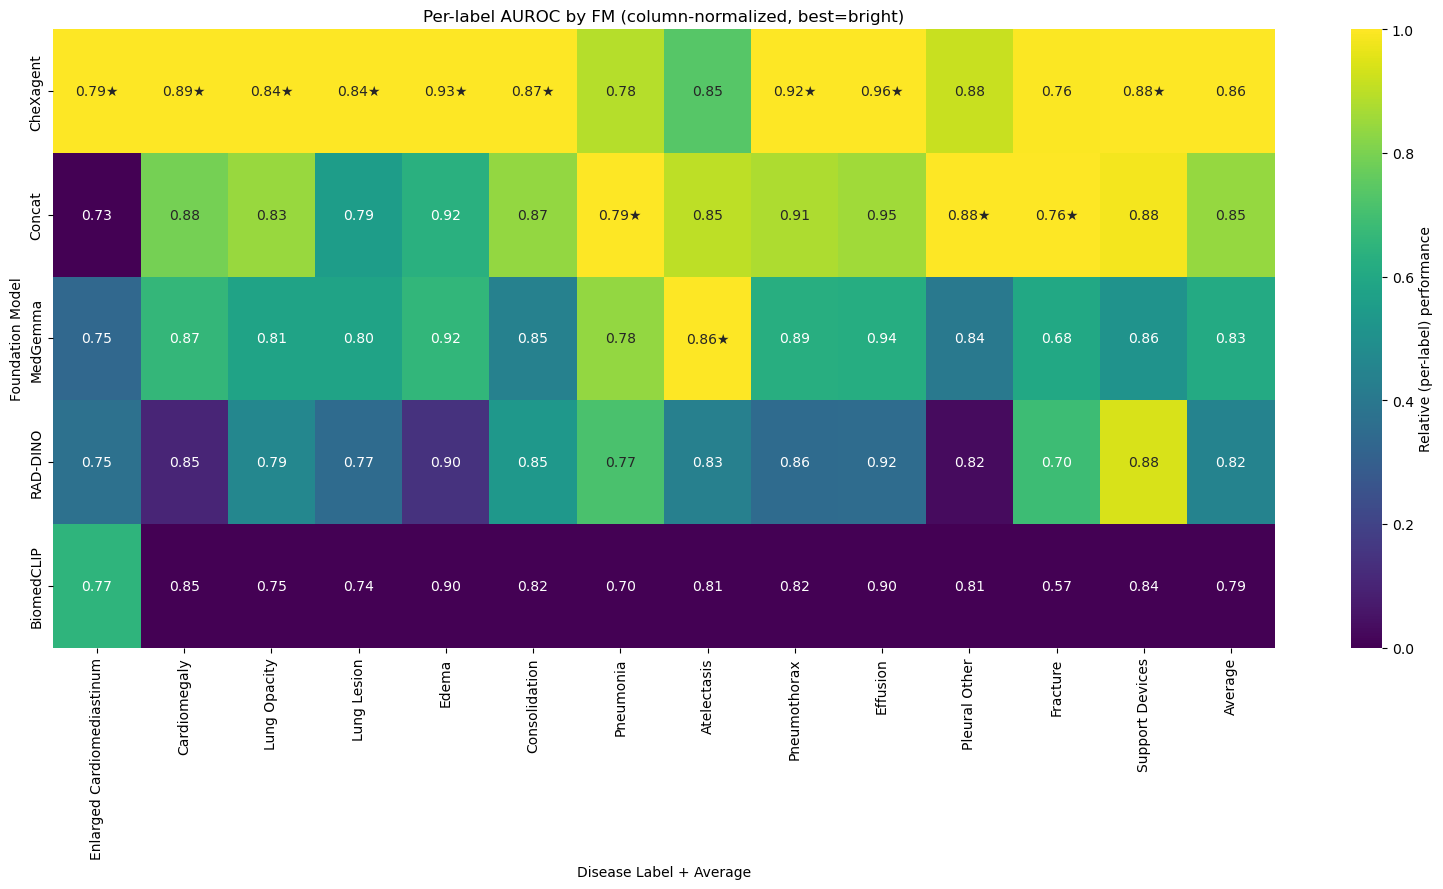

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_per_label_heatmap_ranked(per_label_results: Dict[str, Dict[str, float]],
                                  label_cols: List[str],
                                  title: str = "Per-label AUROC by Foundation Model",
                                  add_average: bool = True,
                                  sort_rows_by_avg: bool = True):
    """
    Colors are normalized per label (column) so brightest = best FM for that label.
    Adds an 'Average' column (macro AUROC across labels) if add_average=True.
    Rows can be sorted by that Average descending.
    """
    # 1) build wide DF of *true AUROC* scores
    df_true = pd.DataFrame(per_label_results).T
    for c in label_cols:
        if c not in df_true.columns:
            df_true[c] = np.nan
    df_true = df_true[label_cols]  # enforce order

    # 2) optional average column (macro across labels)
    if add_average:
        df_true["Average"] = df_true[label_cols].mean(axis=1)

    # 3) sorting by average (desc)
    if sort_rows_by_avg and "Average" in df_true.columns:
        df_true = df_true.sort_values("Average", ascending=False)

    # 4) make a *normalized* copy for coloring (per column min-max)
    df_norm = df_true.copy()
    cols_to_norm = label_cols  # do not normalize the Average column
    for c in cols_to_norm:
        col = df_norm[c].to_numpy(dtype=float)
        cmin, cmax = np.nanmin(col), np.nanmax(col)
        if np.isfinite(cmin) and np.isfinite(cmax) and cmax > cmin:
            df_norm[c] = (col - cmin) / (cmax - cmin)
        else:
            # All same or all NaN -> set to 0.5 mid-gray
            df_norm[c] = 0.5

    # Keep Average as its *absolute* value scaled to [0,1] for color or leave as mid-gray
    if "Average" in df_norm.columns:
        # color Average by its rank among rows to make it meaningful
        avg_vals = df_true["Average"].to_numpy()
        if np.isfinite(avg_vals).all() and np.nanmax(avg_vals) > np.nanmin(avg_vals):
            df_norm["Average"] = (avg_vals - np.nanmin(avg_vals)) / (np.nanmax(avg_vals) - np.nanmin(avg_vals))
        else:
            df_norm["Average"] = 0.5

    # 5) create annotation text from *true* values, with a star on column-wise maxima
    annot = df_true.copy().astype(float)
    annot_text = annot.applymap(lambda v: ("" if np.isnan(v) else f"{v:.2f}"))

    # add stars on per-label winners (exclude 'Average')
    for c in label_cols:
        # handle ties: mark all maxima
        col_vals = df_true[c]
        max_val = col_vals.max()
        if pd.notna(max_val):
            winners = col_vals.index[col_vals == max_val]
            for r in winners:
                annot_text.loc[r, c] = f"{annot_text.loc[r, c]}★"

    # 6) plot
    plt.figure(figsize=(16, 9))
    ax = sns.heatmap(
        df_norm,
        annot=annot_text,
        fmt="",
        cmap="viridis",          # brighter = better
        cbar_kws={'label': 'Relative (per-label) performance'},
        vmin=0.0, vmax=1.0
    )
    ax.set_title(title)
    ax.set_xlabel("Disease Label" + (" + Average" if "Average" in df_true.columns else ""))
    ax.set_ylabel("Foundation Model")
    plt.tight_layout()
    plt.show()

plot_per_label_heatmap_ranked(fm_perlabel, label_cols,
                              title="Per-label AUROC by FM (column-normalized, best=bright)")

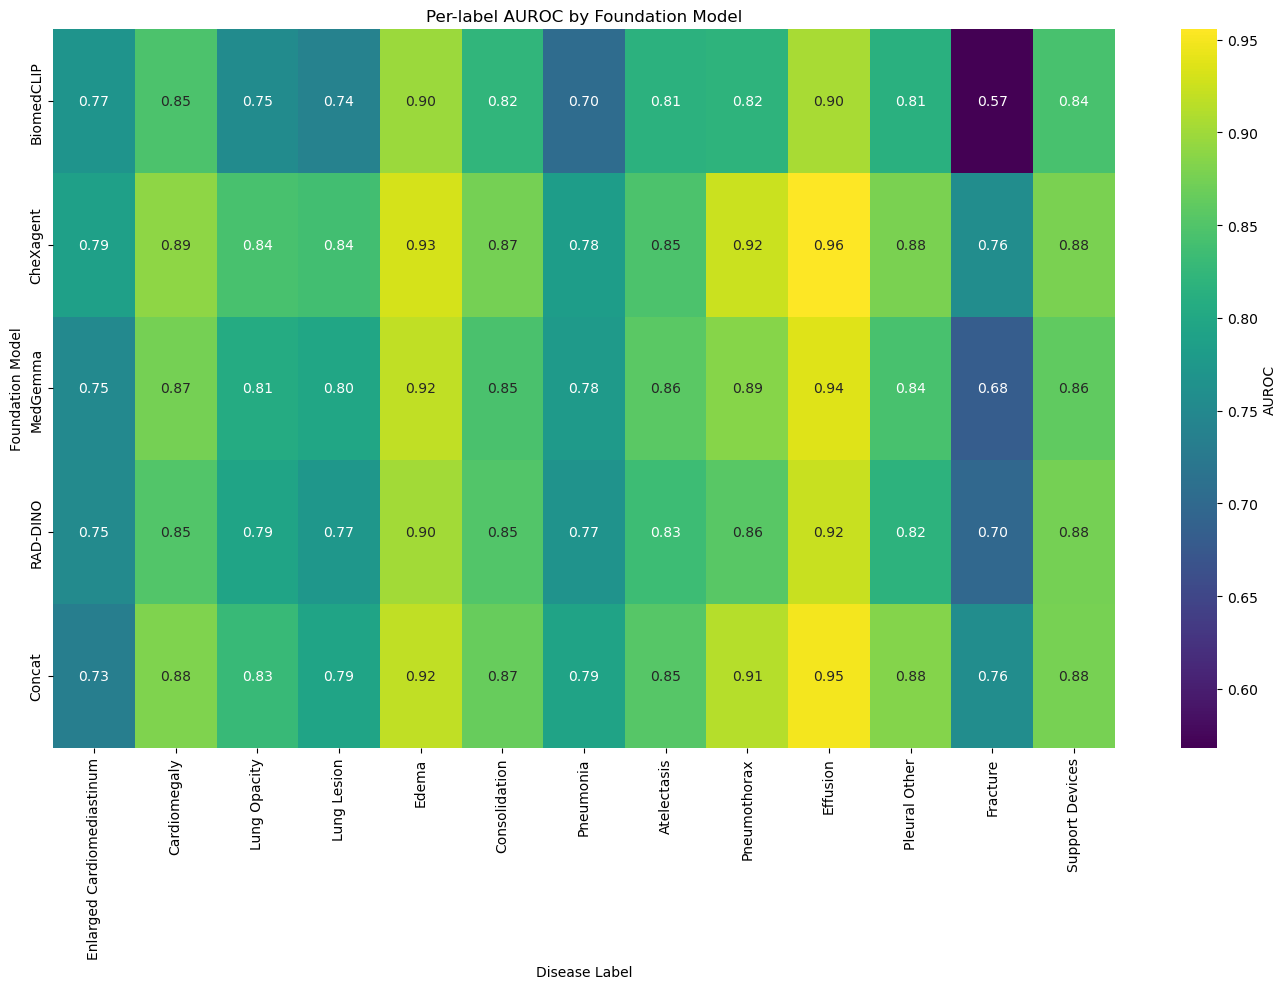

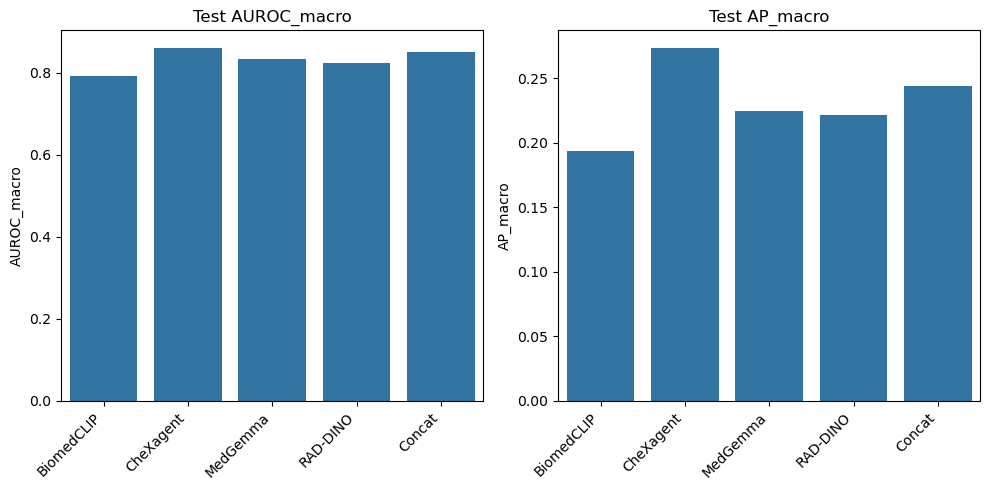

In [16]:
def plot_fm_summary_bars(fm_results: Dict[str, Dict[str, Dict[str, float]]],
                         metrics=("AUROC_macro","AP_macro")):
    rows = []
    for fm, rr in fm_results.items():
        for split in ["valid","test"]:
            row = {"FM": fm, "Split": split}
            for m in metrics:
                row[m] = rr[split][m]
            rows.append(row)
    df = pd.DataFrame(rows)
    plt.figure(figsize=(10,5))
    for i, m in enumerate(metrics, 1):
        ax = plt.subplot(1, len(metrics), i)
        sns.barplot(data=df[df["Split"]=="test"], x="FM", y=m)
        plt.xticks(rotation=45, ha="right")
        ax.set_title(f"Test {m}")
        ax.set_ylabel(m); ax.set_xlabel("")
    plt.tight_layout(); plt.show()

plot_per_label_heatmap(fm_perlabel, label_cols)
plot_fm_summary_bars(fm_results, metrics=("AUROC_macro","AP_macro"))

## saving Embeddings to file

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

def samples_to_dataframe(samples, label_cols, emb_prefix="emb"):
    """
    Convert MimicDataset .load_all() samples into a DataFrame.
    Each row = one sample with patient_id, study_id, labels..., emb...
    """
    patient_ids = [s["patient_id"] for s in samples]
    study_ids   = [s["study_id"] for s in samples]
    labels      = np.vstack([s["lab"] for s in samples]).astype(int)
    embs        = np.vstack([s["emb"].reshape(-1) for s in samples]).astype(np.float32)

    df = pd.DataFrame({
        "patient_id": patient_ids,
        "study_id": study_ids,
    })

    # add labels
    for j, lab in enumerate(label_cols):
        df[lab] = labels[:, j]

    # add embeddings
    emb_cols = [f"{emb_prefix}_emb_{i:04d}" for i in range(embs.shape[1])]
    emb_df = pd.DataFrame(embs, columns=emb_cols)
    df = pd.concat([df, emb_df], axis=1)
    return df

# Example: label names after renaming
label_cols = [
    "Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
    "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Effusion",
    "Pleural Other","Fracture","Support Devices"
]

outdir = Path("exports")
outdir.mkdir(exist_ok=True)

for split in ["train", "valid", "test"]:
    for fm in FMS:
        df = samples_to_dataframe(splits[split][fm], label_cols, emb_prefix=fm)
        df.to_csv(outdir / f"{fm.lower()}_{split}.parquet", index=False)
        print(f"Saved {fm} {split} → {outdir}/{fm.lower()}_{split}.csv")

# df = pd.read_parquet("exports/biomedclip_train.parquet")
# print(df.shape)

Saved BiomedCLIP train → exports/biomedclip_train.csv
Saved CheXagent train → exports/chexagent_train.csv
Saved MedGemma train → exports/medgemma_train.csv
Saved RAD-DINO train → exports/rad-dino_train.csv
Saved BiomedCLIP valid → exports/biomedclip_valid.csv
Saved CheXagent valid → exports/chexagent_valid.csv
Saved MedGemma valid → exports/medgemma_valid.csv
Saved RAD-DINO valid → exports/rad-dino_valid.csv
Saved BiomedCLIP test → exports/biomedclip_test.csv
Saved CheXagent test → exports/chexagent_test.csv
Saved MedGemma test → exports/medgemma_test.csv
Saved RAD-DINO test → exports/rad-dino_test.csv
